# Schemas

## Download and install Spark

In [71]:
!ls

police-station.csv   sample_data		spark-2.3.1-bin-hadoop2.7.tgz
reported-crimes.csv  spark-2.3.1-bin-hadoop2.7	spark-warehouse


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [985 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:14 

## Setup environment

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [ ]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2022-10-22 19:26:20--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [          <=>       ]   1.68G  1.37MB/s    in 12m 33s 

2022-10-22 19:38:54 (2.28 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1799378376]

total 1977812
-rw-r--r--  1 root root 1799378376 Oct 22 13:31 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x  1 root root       4096 Oct 20 13:33  sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018  spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018  spark-2.3.1-bin-hadoop2.7.tgz


In [ ]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 1977812
-rw-r--r--  1 root root 1799378376 Oct 22 13:31 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Oct 20 13:33 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz


In [72]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Schemas

In [ ]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
from pyspark.sql.types import StructField, StructType, TimestampType, StringType, BooleanType, DoubleType, IntegerType 

In [ ]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
labels = [
    ('ID', StringType()),
 ('Case Number', StringType()),
 ('Date', TimestampType()),
 ('Block', StringType()),
 ('IUCR', StringType()), 
 ('Primary Type', StringType()),
 ('Description', StringType()),
 ('Location Description', StringType()),
 ('Arrest', StringType()),
 ('Domestic', BooleanType()),
 ('Beat', StringType()),
 ('District', StringType()),
 ('Ward', StringType()),
 ('Community Area', StringType()),
 ('FBI Code', StringType()),
 ('X Coordinate', StringType()),
 ('Y Coordinate', StringType()),
 ('Year', IntegerType()),
 ('Updated On', StringType()),
 ('Latitude', DoubleType()),
 ('Longitude', DoubleType()),
 ('Location' , StringType()),
]

In [ ]:
schema = StructType([StructField (x[0], x[1], True) for x in labels])

In [ ]:
rc = spark.read.csv('reported-crimes.csv', schema=schema)

In [ ]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [73]:
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

#Working with columns
##Displaying only the first 5 rows of the column name IUCR

In [24]:
rc.select('IUCR').show(5)

+----+
|IUCR|
+----+
|IUCR|
|0486|
|0870|
|0810|
|2023|
+----+
only showing top 5 rows



In [25]:
rc.select(rc.IUCR).show(5)

+----+
|IUCR|
+----+
|IUCR|
|0486|
|0870|
|0810|
|2023|
+----+
only showing top 5 rows



In [26]:
rc.select(col('IUCR')).show(5)

+----+
|IUCR|
+----+
|IUCR|
|0486|
|0870|
|0810|
|2023|
+----+
only showing top 5 rows



In [74]:
rc.select('Case Number', 'Date', 'Arrest').show(4)

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   HY411648|2015-09-05 13:30:00| false|
|   HY411615|2015-09-04 11:30:00| false|
|   JC213529|2018-09-01 00:01:00| false|
|   HY411595|2015-09-05 12:45:00|  true|
+-----------+-------------------+------+
only showing top 4 rows



##Adding a column with name One with entries all 1s

In [28]:
from pyspark.sql.functions import lit

In [75]:
rc.withColumn('One', lit(1)).show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|One|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|

#Removing the column IUCR

In [76]:
rc.drop('IUCR')
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [31]:
#Working with rows
##Adding the reported crimes for an additional day, 12-Nov-2018, to our dataset.

In [32]:
one_day = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-12'))
one_day.count()

3

In [77]:
rc.union(one_day).orderBy('Date', ascending= False).show(5)

+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11516594|   JB528186|2018-11-12 00:00:00| 049XX S PRAIRIE AVE|2826|      OTHER OFFENSE|HARASSMENT BY ELE...|               OTHER|

In [78]:
rc.groupBy('Primary Type').count().show()

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|OFFENSE INVOLVING...|  46527|
|CRIMINAL SEXUAL A...|   1140|
|            STALKING|   3388|
|PUBLIC PEACE VIOL...|  47785|
|           OBSCENITY|    585|
|NON-CRIMINAL (SUB...|      9|
|               ARSON|  11157|
|   DOMESTIC VIOLENCE|      1|
|            GAMBLING|  14422|
|   CRIMINAL TRESPASS| 193371|
|             ASSAULT| 418519|
|      NON - CRIMINAL|     38|
|LIQUOR LAW VIOLATION|  14068|
| MOTOR VEHICLE THEFT| 314130|
|               THEFT|1418493|
|             BATTERY|1232265|
|             ROBBERY| 255601|
|            HOMICIDE|   9478|
|           RITUALISM|     23|
|    PUBLIC INDECENCY|    161|
+--------------------+-------+
only showing top 20 rows



In [38]:
rc.groupBy('Primary Type').count().orderBy('count', ascending=False).show(10)

+-------------------+-------+
|       Primary Type|  count|
+-------------------+-------+
|              THEFT|1614385|
|            BATTERY|1402600|
|    CRIMINAL DAMAGE| 872478|
|          NARCOTICS| 744255|
|            ASSAULT| 496760|
|      OTHER OFFENSE| 475927|
|           BURGLARY| 420446|
|MOTOR VEHICLE THEFT| 358970|
| DECEPTIVE PRACTICE| 335064|
|            ROBBERY| 287426|
+-------------------+-------+
only showing top 10 rows



##Find the percentage of reported crimes that resulted in an arrest

In [40]:
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
|Arrest|
| false|
|  true|
+------+



In [41]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [43]:
rc.filter(col('Arrest') == True).count() / rc.select('Arrest').count()

0.2637873884373322

##Find the top 3 locations for reported crimes

In [44]:
rc.groupBy('Location Description').count().show()

+--------------------+------+
|Location Description| count|
+--------------------+------+
|   RAILROAD PROPERTY|    15|
|SCHOOL - PRIVATE ...|   498|
|AIRPORT TERMINAL ...|  2194|
|VEHICLE - COMMERCIAL|   461|
|EXPRESSWAY EMBANK...|     1|
|POLICE FACILITY/V...| 18580|
|RESIDENCE - YARD ...|  7931|
|               MOTEL|     7|
|CHA PARKING LOT /...|  1143|
|            SIDEWALK|723407|
|AIRPORT TERMINAL ...|   108|
|PUBLIC GRAMMAR SC...|     1|
|OTHER RAILROAD PR...|   281|
|CTA GARAGE / OTHE...| 10278|
|            CAR WASH|  3261|
|   TRUCKING TERMINAL|     1|
|    AIRPORT/AIRCRAFT| 16236|
|            HOSPITAL|    12|
|MEDICAL/DENTAL OF...|  7431|
|    FEDERAL BUILDING|   930|
+--------------------+------+
only showing top 20 rows



In [45]:
rc.groupBy('Location Description').count().orderBy('count', ascending=False).show(3)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1987684|
|           RESIDENCE|1289226|
|           APARTMENT| 854831|
+--------------------+-------+
only showing top 3 rows



##Built-in Functions

In [46]:
from pyspark.sql import functions

In [47]:
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

##String Functions
Display the Primary Type column in lower and upper characters, and the first 4 characters of the column

In [48]:
from pyspark.sql.functions import lower, upper, substring

In [49]:
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [50]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [79]:
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'),1,4)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
|              theft|              THEFT|                         THEF|
|              theft|              THEFT|                         THEF|
|          narcotics|          NARCOTICS|                         NARC|
|            assault|            ASSAULT|                         ASSA|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



##Numeric Funtions
Show the oldest date and the most recent date

In [52]:
from pyspark.sql.functions import min,max

In [80]:
rc.select(min(col('Date')),max(col('Date'))).show(1)

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2018-11-10 23:55:00|
+-------------------+-------------------+



##Date Functions
What is 3 days earlier than the oldest date and 3 days later than the most recent date

In [54]:
from pyspark.sql.functions import date_add, date_sub

In [55]:
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [81]:
rc.select(date_sub(min(col('Date')),3),date_add(max(col('Date')),3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-13|
+----------------------+----------------------+



##Joins
Download police station data

In [63]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
!ls -1

--2022-10-22 21:17:57--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2022-10-22 21:17:57 (395 MB/s) - ‘police-station.csv’ saved [5699]

police-station.csv
reported-crimes.csv
sample_data
spark-2.3.1-bin-hadoop2.7
spark-2.3.1-bin-hadoop2.7.tgz
spark-warehouse


In [64]:
ps = spark.read.csv('police-station.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

The reported crimes dataset has only district number. Add the district name by joining with the police station dataset

In [65]:
rc.cache()
rc.count()

7653770

In [66]:
ps.select(col('DISTRICT')).distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [82]:
rc.select('District').distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     021|
|     002|
+--------+



In [83]:
from pyspark.sql.functions import lpad

In [84]:
ps.select(lpad(col('DISTRICT'),3,'0')).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [85]:
ps = ps.withColumn('Format_district', lpad(col('DISTRICT'),3,'0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [89]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').drop(
'ADDRESS',
'CITY',
'STATE',
'ZIP',
'WEBSITE',
'PHONE',
'FAX',
'TTY',
'X COORDINATE',
'Y COORDINATE',
'LATITUDE',
'LONGITUDE',
'LOCATION',
).show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|       Deeri

## Challenge questions
**What is the most frequently reported non-criminal activity?**

In [90]:
nc = rc.filter((col('Primary Type') == 'NON - CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL')  | (col('Primary Type') == 'NON - CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+----+--------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|  Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|NON - CRIMINAL|   FOID - REVOCATION|           RESIDENCE|  true|   false|1513

In [91]:
nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime.**

In [93]:
from pyspark.sql.functions import dayofweek, date_format

In [94]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017318|
|                 Wed| 974234|
|                 Tue| 968359|
|                 Sat| 965451|
|                 Thu| 964947|
|                 Mon| 953084|
|                 Sun| 912283|
+--------------------+-------+



In [95]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [96]:
cnt = [x[1] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
cnt

[912283, 953084, 964947, 965451, 974234, 1017318, 968359]

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
cp = pd.DataFrame({'Day_of_week': dow, 'Count': cnt})
cp.head(7)

,Day_of_week,Count
0,Sun,912283
1,Mon,953084
2,Thu,964947
3,Sat,965451
4,Wed,974234
5,Fri,1017318
6,Tue,968359


Text(0.5, 1.0, 'No. of reported crimes per day of week since 2001')

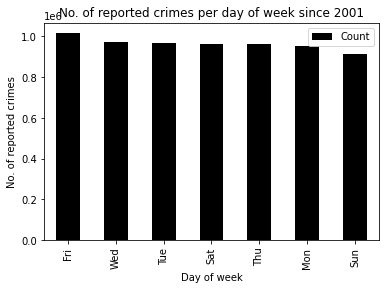

In [102]:
cp.sort_values('Count', ascending=False).plot(kind='bar', color='black', x='Day_of_week', y='Count')
plt.xlabel('Day of week')
plt.ylabel('No. of reported crimes')
plt.title('No. of reported crimes per day of week since 2001')